<a href="https://colab.research.google.com/github/JuliethLopez/dlaicoursePractica/blob/master/Homework%2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we'll use the **daily-min-temperatures** dataset which have daily data of temperature.

In [32]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [33]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [34]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-11 02:59:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-08-11 02:59:58 (3.95 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



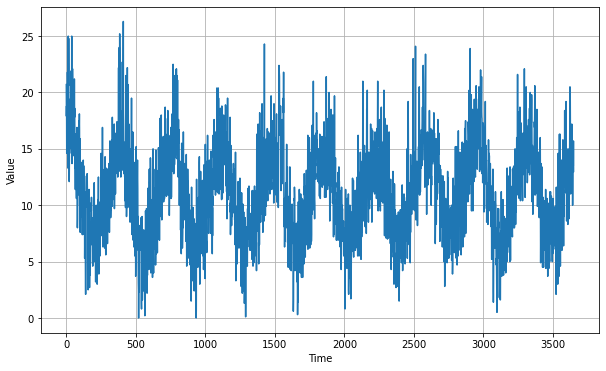

In [35]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i=0
  for line in reader:
    temps.append(float(line[1]))
    time_step.append(i)
    i += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [36]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [38]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(32, kernel_size=5, padding='causal', activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 27)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 19ms/step - loss: 11.7445 - mae: 12.2442
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 11.7417 - mae: 12.2414
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 11.7376 - mae: 12.2373
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 11.7325 - mae: 12.2322
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 11.7266 - mae: 12.2263
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 11.7200 - mae: 12.2197
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 11.7126 - mae: 12.2122
Epoch 8/100
10/10 [==============================] - 0s 25ms/step - loss: 11.7041 - mae: 12.2038
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 11.6947 - mae: 12.1943
Epoch 10/100
10/10 [=====

(1e-08, 0.001, 0.0, 60.0)

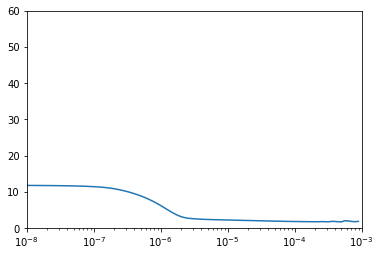

In [43]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 60])

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(32, kernel_size=5, padding='causal', activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 27)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100) #100
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
25/25 [==============================] - 0s 14ms/step - loss: 5.1527 - mae: 5.6327
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 2.3613 - mae: 2.8214
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 2.0128 - mae: 2.4663
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 1.8968 - mae: 2.3496
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 1.8560 - mae: 2.3085
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 1.8281 - mae: 2.2813
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 1.8069 - mae: 2.2596
Epoch 8/100
25/25 [==============================] - 0s 14ms/step - loss: 1.7941 - mae: 2.2465
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 1.7813 - mae: 2.2334
Epoch 10/100
25/25 [==============================] - 0s 17ms/step - loss: 1.7683 - mae: 2.2201
Epoch 11/100
25/25 [=============================

In [45]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

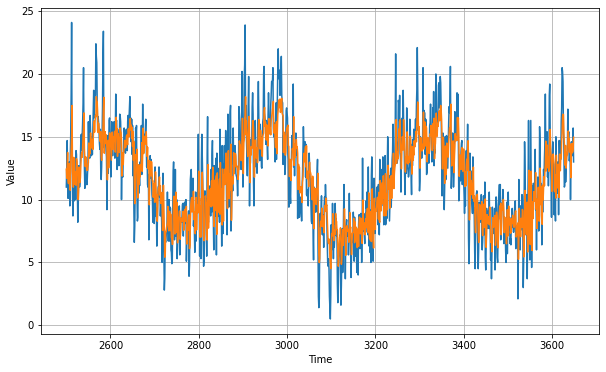

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7879256

In [48]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.41559  11.705876 12.764736 ... 13.784414 13.867846 14.962761]
